Implementation of Vector db similarity algorithms based on high density generated dataset

In [5]:
!pip install -q faiss-cpu tqdm seaborn scikit-learn pandas

In [6]:
#!/usr/bin/env python
# Vector Similarity Search Implementations
# A comprehensive guide to different vector search algorithms

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import GaussianRandomProjection
from scipy.spatial.distance import cdist
import faiss
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
import multiprocessing
from functools import partial
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Set random seed for reproducibility
np.random.seed(42)

print("Setting up the environment for vector similarity search algorithms...")

# Function to generate dummy data
def generate_dummy_data(n_samples=10000, n_features=128, n_centers=10):
    """Generate dummy high-dimensional data for vector search"""
    print(f"Generating {n_samples} samples with {n_features} dimensions...")

    # Generate blob clusters
    X, y = make_blobs(n_samples=n_samples,
                      n_features=n_features,
                      centers=n_centers,
                      cluster_std=5.0,
                      random_state=42)

    # Normalize vectors to unit length
    X = normalize(X)

    # Generate random metadata
    categories = ['electronics', 'clothing', 'food', 'books', 'toys']
    price_range = [10, 1000]
    ratings_range = [1, 5]

    metadata = {
        'category': np.random.choice(categories, n_samples),
        'price': np.random.uniform(price_range[0], price_range[1], n_samples),
        'rating': np.random.uniform(ratings_range[0], ratings_range[1], n_samples),
        'in_stock': np.random.choice([True, False], n_samples),
        'cluster': y
    }

    metadata_df = pd.DataFrame(metadata)

    # Create query vectors - sample a few from the dataset
    query_indices = np.random.choice(n_samples, 5, replace=False)
    query_vectors = X[query_indices]

    return X, query_vectors, metadata_df


Setting up the environment for vector similarity search algorithms...


In [8]:
# Utility function to evaluate search quality and performance
def evaluate_algorithm(name, results, ground_truth, query_time):
    """Evaluate search quality and performance"""
    actual_indices = set(ground_truth)
    retrieved_indices = set(results)

    # Calculate recall
    common = actual_indices.intersection(retrieved_indices)
    recall = len(common) / len(actual_indices) if len(actual_indices) > 0 else 0

    return {
        'algorithm': name,
        'recall': recall,
        'query_time_ms': query_time * 1000,  # Convert to milliseconds
        'num_results': len(results)
    }

In [9]:
# Function to visualize results
def plot_performance_comparison(results_df):
    """Plot performance comparison between algorithms"""
    plt.figure(figsize=(14, 6))

    # Plot query time
    plt.subplot(1, 2, 1)
    sns.barplot(x='algorithm', y='query_time_ms', data=results_df)
    plt.title('Query Time Comparison (ms)')
    plt.ylabel('Time (ms)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot recall
    plt.subplot(1, 2, 2)
    sns.barplot(x='algorithm', y='recall', data=results_df)
    plt.title('Recall Comparison')
    plt.ylabel('Recall')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Setting up completed. Let's implement each algorithm...")

Setting up completed. Let's implement each algorithm...


# ----------------------------------------------------------------------------------------
# 1. Random Projection
# ----------------------------------------------------------------------------------------

In [10]:
class RandomProjectionSearch:
    """
    Implementation of Random Projection for vector similarity search.
    Random Projection works by projecting high-dimensional vectors into a lower-dimensional space
    while approximately preserving distances between points.
    """

    def __init__(self, n_components=64):
        self.n_components = n_components
        self.projector = GaussianRandomProjection(n_components=n_components, random_state=42)
        self.projected_data = None
        self.original_data = None
        self.nn_index = None

    def fit(self, data):
        """Project data to lower dimensions and build nearest neighbor index"""
        self.original_data = data
        self.projected_data = self.projector.fit_transform(data)

        # Use a standard nearest neighbor search in the projected space
        self.nn_index = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean')
        self.nn_index.fit(self.projected_data)

        return self

    def search(self, query, k=10):
        """Search for nearest neighbors in the projected space"""
        projected_query = self.projector.transform(query.reshape(1, -1))
        distances, indices = self.nn_index.kneighbors(projected_query, n_neighbors=k)

        return indices[0]  # Return the indices of the nearest neighbors

    def pre_filter_search(self, query, k=10, filter_func=None):
        """Search with pre-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Apply filter first to get candidate indices
        filtered_indices = np.where(filter_func)[0]

        if len(filtered_indices) == 0:
            return np.array([])

        # Only project and search in the filtered subset
        filtered_data = self.original_data[filtered_indices]

        # Project query and filtered data
        projected_query = self.projector.transform(query.reshape(1, -1))
        projected_filtered_data = self.projector.transform(filtered_data)

        # Create a temporary nearest neighbor index for the filtered data
        temp_nn = NearestNeighbors(n_neighbors=min(k, len(filtered_indices)), algorithm='auto')
        temp_nn.fit(projected_filtered_data)

        # Search
        distances, local_indices = temp_nn.kneighbors(projected_query)

        # Map back to the original indices
        return filtered_indices[local_indices[0]]

    def post_filter_search(self, query, k=10, filter_func=None):
        """Search with post-filtering"""
        # Get more results initially to account for filtering
        multiplier = 3  # Get 3x more results initially
        initial_k = k * multiplier

        # Perform the search
        distances, indices = self.nn_index.kneighbors(
            self.projector.transform(query.reshape(1, -1)),
            n_neighbors=min(initial_k, len(self.projected_data))
        )

        indices = indices[0]

        if filter_func is None:
            return indices[:k]

        # Apply filter to the results
        filtered_mask = filter_func[indices]
        filtered_indices = indices[filtered_mask]

        # Return at most k results
        return filtered_indices[:k]

# ----------------------------------------------------------------------------------------
# 2. Product Quantization
# ----------------------------------------------------------------------------------------

In [23]:

import faiss

class ProductQuantizationSearch:
    """
    Implementation of Product Quantization for vector similarity search.
    Product Quantization divides vectors into subvectors and quantizes each subvector separately,
    enabling efficient approximate nearest neighbor search.
    """

    def __init__(self, n_quantizers=8, nbits=8):
        self.n_quantizers = n_quantizers  # Number of subquantizers (M)
        self.nbits = nbits  # Number of bits per subquantizer (usually 4, 6, or 8)
        self.original_data = None
        self.index = None

    def fit(self, data):
        """Build a FAISS index with Product Quantization"""
        self.original_data = data
        n, d = data.shape

        # Ensure n_quantizers divides d
        if d % self.n_quantizers != 0:
            # Adjust n_quantizers to be a divisor of d
            factors = [i for i in range(1, d + 1) if d % i == 0]
            self.n_quantizers = min(factors, key=lambda x: abs(x - self.n_quantizers))
            print(f"Adjusted n_quantizers to {self.n_quantizers} to be compatible with data dimensions")

        # Convert data to float32 which is required by FAISS
        data = data.astype(np.float32)

        # Create FAISS PQ index
        self.index = faiss.IndexPQ(d, self.n_quantizers, self.nbits)

        # Train index (sample up to 10,000 points for training if necessary)
        # The number of training points must be >= 2**nbits for each subquantizer,
        # or at least the total number of codebook entries (n_quantizers * 2**nbits)
        # or simply >= 2**nbits for the whole index, depending on the specific PQ implementation details.
        # FAISS docs typically suggest nx >= k (where k=2**nbits for IndexPQ)
        min_train_points = 2**self.nbits

        if n < min_train_points:
             print(f"Warning: Number of data points ({n}) is less than the minimum required for PQ training ({min_train_points}). Index training skipped.")
             # In a real scenario, you might choose a different index type or raise an error
             # For this example, we'll proceed without training, which will likely impact search quality
        else:
            if n > 10000:
                training_indices = np.random.choice(n, 10000, replace=False)
                self.index.train(data[training_indices])
            else:
                self.index.train(data)

        # Add all vectors to the index
        self.index.add(data)
        return self

    def search(self, query, k=10):
        """Search for nearest neighbors using Product Quantization"""
        query = query.astype(np.float32).reshape(1, -1)
        distances, indices = self.index.search(query, k)
        return indices[0]

    def pre_filter_search(self, query, k=10, filter_func=None):
        """Search with pre-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Apply filter to get candidate indices
        filtered_indices = np.where(filter_func)[0]

        if len(filtered_indices) == 0:
            return np.array([])

        filtered_data = self.original_data[filtered_indices].astype(np.float32)

        # Add a check for minimum training points for the temporary index
        min_train_points = 2**self.nbits
        if filtered_data.shape[0] < min_train_points:
            # Not enough data points after filtering to train a new PQ index
            # In this case, pre-filtering with PQ is not feasible or meaningful.
            # We can either return an empty array or fall back to a different search method.
            # Returning empty array as it's consistent with no results found after filtering.
            print(f"Pre-filter search for PQ: Not enough filtered data ({filtered_data.shape[0]}) to train temporary index (need at least {min_train_points}). Returning empty results.")
            return np.array([])


        # Create temporary FAISS index
        d = filtered_data.shape[1]
        # Use the same PQ parameters as the main index
        temp_index = faiss.IndexPQ(d, self.n_quantizers, self.nbits)

        # Train and add vectors
        temp_index.train(filtered_data)
        temp_index.add(filtered_data)

        # Search
        query = query.astype(np.float32).reshape(1, -1)
        distances, local_indices = temp_index.search(query, min(k, len(filtered_indices)))

        # Map results back to original indices
        return filtered_indices[local_indices[0]]

    def post_filter_search(self, query, k=10, filter_func=None):
        """Search with post-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Get more initial results to allow filtering
        multiplier = 3
        initial_k = k * multiplier

        query = query.astype(np.float32).reshape(1, -1)
        distances, indices = self.index.search(query, min(initial_k, len(self.original_data)))

        # Ensure indices is not empty in case initial search returned nothing
        if len(indices[0]) == 0:
             return np.array([])

        indices = indices[0]
        # Filter_func needs to be applicable to the original dataset indices
        # so we must ensure the filter_func mask has the same length as the original data
        # The filter_func passed here (e.g., metadata['category'] == 'electronics') is already a boolean mask over the *original* data indices.
        # So, we just need to apply this mask to the indices obtained from the search.

        # Ensure the filter_func is a numpy array for boolean indexing
        if not isinstance(filter_func, np.ndarray):
             filter_func = np.array(filter_func)

        # Apply filter to the results obtained from the search
        # Ensure the indices are within the bounds of the filter_func mask
        valid_indices_mask = indices < len(filter_func)
        valid_indices = indices[valid_indices_mask]

        if len(valid_indices) == 0:
             return np.array([])

        filtered_mask_on_results = filter_func[valid_indices]
        filtered_indices = valid_indices[filtered_mask_on_results]

        return filtered_indices[:k]

# ----------------------------------------------------------------------------------------
# 3. Locality-Sensitive Hashing (LSH)
# ----------------------------------------------------------------------------------------


In [25]:

class LocalitySensitiveHashing:
    """
    Implementation of Locality-Sensitive Hashing for vector similarity search.
    LSH hashes vectors so that similar items are more likely to be hashed to the same bucket.
    """

    def __init__(self, n_projections=10, n_tables=5):
        self.n_projections = n_projections  # Number of random projections per table
        self.n_tables = n_tables  # Number of hash tables
        self.hash_tables = []
        self.random_projections = []
        self.original_data = None

    def _hash_vector(self, vector, projections):
        """Hash a vector using random projections"""
        # Project the vector onto random directions
        projections_result = np.dot(vector, projections.T)

        # Convert to binary: 1 if projection is positive, 0 otherwise
        binary_hash = (projections_result > 0).astype(int)

        # Convert binary array to integer for easier bucket identification
        hash_value = 0
        # Iterate in reverse to maintain correct bit significance
        for i, bit in enumerate(binary_hash[::-1]):
             hash_value += bit * (2 ** i)

        return hash_value

    def fit(self, data):
        """Build LSH hash tables for the data"""
        self.original_data = data
        n, d = data.shape

        # Initialize hash tables and random projections
        self.hash_tables = [{} for _ in range(self.n_tables)]
        self.random_projections = [
            np.random.randn(self.n_projections, d) for _ in range(self.n_tables)
        ]

        # Hash each data point and store in hash tables
        for i, vector in enumerate(data):
            for table_idx, projections in enumerate(self.random_projections):
                hash_value = self._hash_vector(vector, projections)

                # Store the data index in the appropriate bucket
                if hash_value not in self.hash_tables[table_idx]:
                    self.hash_tables[table_idx][hash_value] = []
                self.hash_tables[table_idx][hash_value].append(i)

        return self

    def search(self, query, k=10):
        """Search for nearest neighbors using LSH"""
        # Hash the query using each table's projections
        candidate_indices = set()

        for table_idx, projections in enumerate(self.random_projections):
            hash_value = self._hash_vector(query, projections)

            # Get candidates from the same bucket
            if hash_value in self.hash_tables[table_idx]:
                candidate_indices.update(self.hash_tables[table_idx][hash_value])

        if not candidate_indices:
            # If no candidates found, return empty array
            return np.array([], dtype=int)

        # Convert to list and compute distances to each candidate
        candidate_indices = list(candidate_indices)
        candidates = self.original_data[candidate_indices]
        # Using cosine distance since the data is normalized
        # LSH with random projections is more related to cosine distance
        # compared to Euclidean distance which was used before
        distances = 1 - cdist(query.reshape(1, -1), candidates, metric='cosine').flatten()

        # Sort by distance (for cosine, smaller distance is more similar)
        # Since we used 1 - cosine_similarity, we sort by ascending distance
        sorted_indices = np.argsort(distances)[:k]
        result_indices = [candidate_indices[i] for i in sorted_indices]

        return np.array(result_indices)

    def pre_filter_search(self, query, k=10, filter_func=None):
        """Search with pre-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Apply filter first to get candidate indices from original data
        filtered_original_indices = np.where(filter_func)[0]

        if len(filtered_original_indices) == 0:
            return np.array([])

        # Create a temporary LSH index using *only* the filtered data
        filtered_data = self.original_data[filtered_original_indices]
        temp_lsh = LocalitySensitiveHashing(
            n_projections=self.n_projections,
            n_tables=self.n_tables
        )
        # Fit the temporary index on the filtered subset of data
        temp_lsh.fit(filtered_data)

        # Search using the temporary index. This will return indices relative
        # to the `filtered_data` array (0 to len(filtered_data)-1).
        local_indices = temp_lsh.search(query, k)

        # Map these local indices back to the original data indices
        if len(local_indices) > 0:
            return filtered_original_indices[local_indices]
        else:
            return np.array([])


    def post_filter_search(self, query, k=10, filter_func=None):
        """Search with post-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Get initial candidates without filtering
        candidate_indices = set()

        for table_idx, projections in enumerate(self.random_projections):
            hash_value = self._hash_vector(query, projections)

            # Get candidates from the same bucket
            if hash_value in self.hash_tables[table_idx]:
                candidate_indices.update(self.hash_tables[table_idx][hash_value])

        if not candidate_indices:
            return np.array([], dtype=int)

        # Convert to list for easier processing
        candidate_indices = list(candidate_indices)

        # Apply filter directly using the original filter_func mask
        # filter_func is a boolean mask aligned with original data indices
        # We check if filter_func is True for each candidate index
        try:
            # Ensure filter_func can be indexed by candidate_indices
            # If filter_func is a pandas Series, direct indexing works.
            # If filter_func is a numpy array, need to ensure indices are within bounds.
            filtered_candidates = [
                idx for idx in candidate_indices if filter_func[idx]
            ]
        except IndexError:
             # This might happen if candidate_indices contains indices
             # outside the bounds of the numpy array filter_func.
             print(f"Warning: LSH search returned index out of bounds for filter_func. Indices: {candidate_indices}. filter_func length: {len(filter_func)}. Skipping post-filtering for this query.")
             return np.array([])
        except KeyError:
            # This happens if filter_func is a Series and candidate_indices
            # contains an index not present in the Series index.
             print(f"Warning: LSH search returned index not in filter_func index. Indices: {candidate_indices}. filter_func index: {filter_func.index}. Skipping post-filtering for this query.")
             return np.array([])


        if not filtered_candidates:
            return np.array([], dtype=int)

        # Compute distances to filtered candidates
        candidates = self.original_data[filtered_candidates]
        # Using cosine distance
        distances = 1 - cdist(query.reshape(1, -1), candidates, metric='cosine').flatten()

        # Sort by distance and return the k nearest
        # sort by ascending distance
        sorted_indices_in_filtered = np.argsort(distances)[:k]
        result_indices = [filtered_candidates[i] for i in sorted_indices_in_filtered]

        return np.array(result_indices)

In [27]:
class HNSWFaissSearch:
    """
    Implementation of HNSW using FAISS instead of NMSLIB
    """

    def __init__(self, M=16, ef_construction=200, ef_search=40, metric=faiss.METRIC_L2):
        self.M = M # Number of neighbors in graph construction
        self.ef_construction = ef_construction # Construction time search parameter
        self.ef_search = ef_search # Search time search parameter
        self.metric = metric # Distance metric (e.g., faiss.METRIC_L2, faiss.METRIC_INNER_PRODUCT)
        self.original_data = None
        self.index = None

    def fit(self, data):
        """Build HNSW index using FAISS"""
        self.original_data = data
        n, d = data.shape

        # Convert to float32 for FAISS
        data = data.astype(np.float32)

        # If using Inner Product metric, normalize data
        if self.metric == faiss.METRIC_INNER_PRODUCT:
            # FAISS requires vectors to be normalized for Inner Product search
            faiss.normalize_L2(data)


        # Create HNSW index
        # IndexHNSWFlat stores vectors directly, good for smaller datasets or when memory is not a constraint
        # For larger datasets, consider IndexHNSW
        self.index = faiss.IndexHNSWFlat(d, self.M, self.metric)

        # Set HNSW parameters
        self.index.hnsw.efConstruction = self.ef_construction
        self.index.hnsw.efSearch = self.ef_search # Can be adjusted at search time

        # Add vectors to the index
        self.index.add(data)

        return self

    def search(self, query, k=10):
        """Search for nearest neighbors"""
        query = np.array(query, dtype=np.float32).reshape(1, -1)

        # If using Inner Product metric, normalize query
        if self.metric == faiss.METRIC_INNER_PRODUCT:
             faiss.normalize_L2(query)

        distances, indices = self.index.search(query, k)

        # FAISS returns distance values. For L2, smaller is better. For INNER_PRODUCT, larger is better.
        # Since the `evaluate_algorithm` expects distance where smaller is better (for recall calculation),
        # we should be mindful of the metric. However, the function only uses the indices.
        return indices[0]

    def pre_filter_search(self, query, k=10, filter_func=None):
        """Search with pre-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Apply filter first to get candidate indices from original data
        filtered_original_indices = np.where(filter_func)[0]

        if len(filtered_original_indices) == 0:
            return np.array([])

        # Create a temporary HNSW index using *only* the filtered data
        filtered_data = self.original_data[filtered_original_indices].astype(np.float32)

        if filtered_data.shape[0] == 0:
            return np.array([]) # Handle case where filter results in no data


        # If using Inner Product metric, normalize filtered data for the temporary index
        if self.metric == faiss.METRIC_INNER_PRODUCT:
            faiss.normalize_L2(filtered_data)

        # Create temporary FAISS HNSW index
        d = filtered_data.shape[1]
        temp_index = faiss.IndexHNSWFlat(d, self.M, self.metric)
        temp_index.hnsw.efConstruction = self.ef_construction
        temp_index.hnsw.efSearch = self.ef_search # Use same search param or adjust

        # Add vectors to the temporary index
        temp_index.add(filtered_data)

        # Search using the temporary index. This will return indices relative
        # to the `filtered_data` array (0 to len(filtered_data)-1).
        query = np.array(query, dtype=np.float32).reshape(1, -1)
        if self.metric == faiss.METRIC_INNER_PRODUCT:
            faiss.normalize_L2(query)

        distances, local_indices = temp_index.search(query, min(k, filtered_data.shape[0]))

        # Map these local indices back to the original data indices
        if len(local_indices[0]) > 0:
             return filtered_original_indices[local_indices[0]]
        else:
             return np.array([])


    def post_filter_search(self, query, k=10, filter_func=None):
        """Search with post-filtering"""
        if filter_func is None:
            return self.search(query, k)

        # Get more initial results to allow filtering
        multiplier = 3 # Get 3x more results initially
        initial_k = k * multiplier

        # Perform the search on the full index
        query = np.array(query, dtype=np.float32).reshape(1, -1)
        if self.metric == faiss.METRIC_INNER_PRODUCT:
             faiss.normalize_L2(query)

        distances, indices = self.index.search(query, min(initial_k, len(self.original_data)))

        # Ensure indices is not empty
        if len(indices[0]) == 0:
             return np.array([])

        indices = indices[0] # These are indices relative to the original data

        # Apply filter to the results obtained from the search
        # filter_func is a boolean mask aligned with original data indices
        try:
            # Ensure filter_func can be indexed by the search results indices
            filtered_mask_on_results = filter_func[indices]
            filtered_indices = indices[filtered_mask_on_results]
        except IndexError:
             print(f"Warning: HNSW search returned index out of bounds for filter_func. Indices: {indices}. filter_func length: {len(filter_func)}. Skipping post-filtering for this query.")
             return np.array([])
        except KeyError:
             print(f"Warning: HNSW search returned index not in filter_func index. Indices: {indices}. filter_func index: {filter_func.index}. Skipping post-filtering for this query.")
             return np.array([])


        # Return at most k results
        return filtered_indices[:k]



# ----------------------------------------------------------------------------------------
# Experiment and Comparison
# ----------------------------------------------------------------------------------------


In [29]:
def run_experiments():
    """Run experiments with all algorithms and compare results"""
    print("Running experiments to compare vector search algorithms...")

    # Generate dummy data
    data, queries, metadata = generate_dummy_data(n_samples=10000, n_features=128)

    # Define filters for testing
    category_filter = metadata['category'] == 'electronics'
    price_filter = metadata['price'] < 100
    combined_filter = (metadata['category'] == 'electronics') & (metadata['price'] < 100)

    filters = {
        'no_filter': None,
        'category_filter': category_filter,
        'price_filter': price_filter,
        'combined_filter': combined_filter
    }

    # Define algorithms to test
    algorithms = [
        ('Random Projection', RandomProjectionSearch(n_components=32)),
        ('Product Quantization', ProductQuantizationSearch(n_quantizers=8)),
        ('LSH', LocalitySensitiveHashing(n_projections=8, n_tables=5)),
        ('HNSW', HNSWFaissSearch(M=16, ef_construction=200, ef_search=50, metric=faiss.METRIC_INNER_PRODUCT))
    ]

    # Compute ground truth (exact nearest neighbors)
    exact_nn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')
    exact_nn.fit(data)

    results = []

    # Test each algorithm with different filtering approaches
    for name, algo in algorithms:
        print(f"\nTraining {name}...")
        algo.fit(data)

        for query_idx, query in enumerate(queries):
            print(f"  Testing query {query_idx+1}/{len(queries)}...")

            # Get ground truth for this query
            _, gt_indices = exact_nn.kneighbors(query.reshape(1, -1))
            ground_truth = gt_indices[0]

            for filter_name, filter_func in filters.items():
                if filter_name == 'no_filter':
                    # Standard search
                    start_time = time.time()
                    indices = algo.search(query, k=10)
                    search_time = time.time() - start_time

                    results.append(evaluate_algorithm(
                        f"{name} (Standard)",
                        indices,
                        ground_truth,
                        search_time
                    ))
                else:
                    # Pre-filtering
                    start_time = time.time()
                    pre_indices = algo.pre_filter_search(query, k=10, filter_func=filter_func)
                    pre_time = time.time() - start_time

                    results.append(evaluate_algorithm(
                        f"{name} (Pre-filter: {filter_name})",
                        pre_indices,
                        ground_truth,
                        pre_time
                    ))

                    # Post-filtering
                    start_time = time.time()
                    post_indices = algo.post_filter_search(query, k=10, filter_func=filter_func)
                    post_time = time.time() - start_time

                    results.append(evaluate_algorithm(
                        f"{name} (Post-filter: {filter_name})",
                        post_indices,
                        ground_truth,
                        post_time
                    ))

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Aggregate results by algorithm
    agg_results = results_df.groupby('algorithm').agg({
        'recall': 'mean',
        'query_time_ms': 'mean',
        'num_results': 'mean'
    }).reset_index()

    print("\nResults Summary:")
    print(agg_results)

    # Plot results
    plot_performance_comparison(agg_results)

    return results_df, agg_results



# ----------------------------------------------------------------------------------------
# Main Execution Script
# ----------------------------------------------------------------------------------------



    Vector Similarity Search Algorithms - Comparative Implementation
    
    This notebook implements and compares four popular vector search algorithms:
    1. Random Projection
    2. Product Quantization
    3. Locality-Sensitive Hashing (LSH)
    4. Hierarchical Navigable Small World (HNSW)
    
    Each algorithm is implemented with both pre-filtering and post-filtering
    approaches for metadata filtering.
    
    We'll generate a dummy dataset and compare the algorithms in terms of:
    - Search quality (recall)
    - Search speed (query time)
    
    Let's get started!
    
Running experiments to compare vector search algorithms...
Generating 10000 samples with 128 dimensions...

Training Random Projection...
  Testing query 1/5...
  Testing query 2/5...
  Testing query 3/5...
  Testing query 4/5...
  Testing query 5/5...

Training Product Quantization...
  Testing query 1/5...
Pre-filter search for PQ: Not enough filtered data (170) to train temporary index (need at least

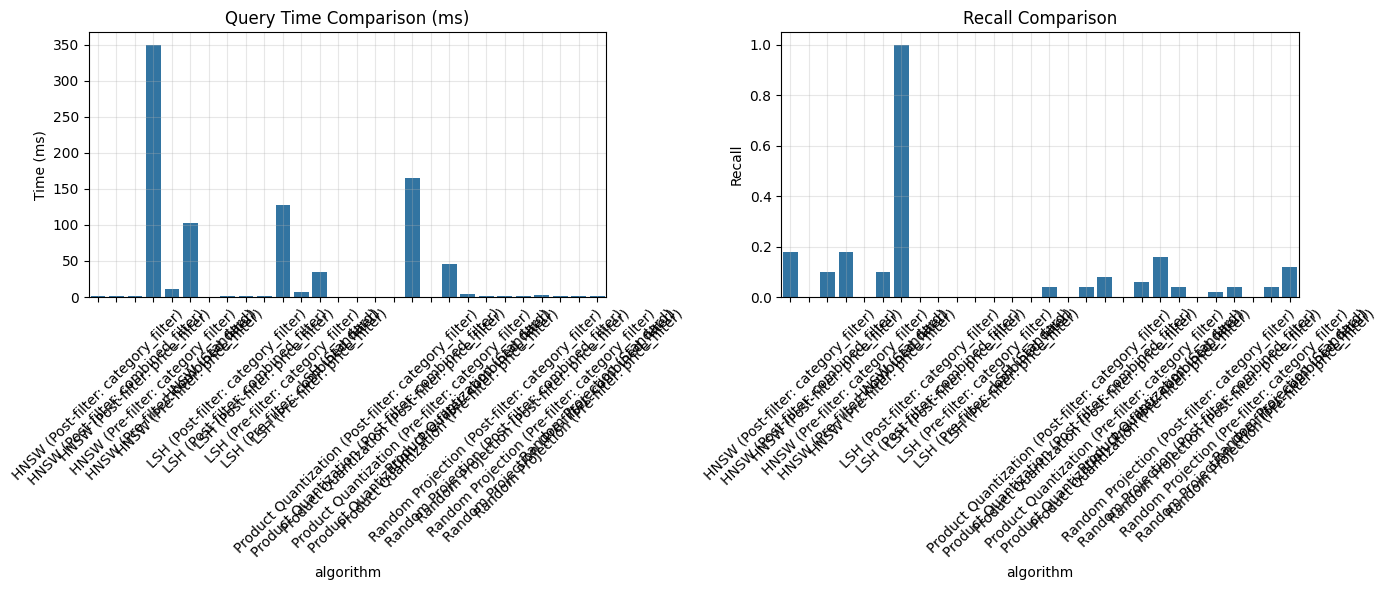


Visualizing algorithms' performance across different filtering approaches...


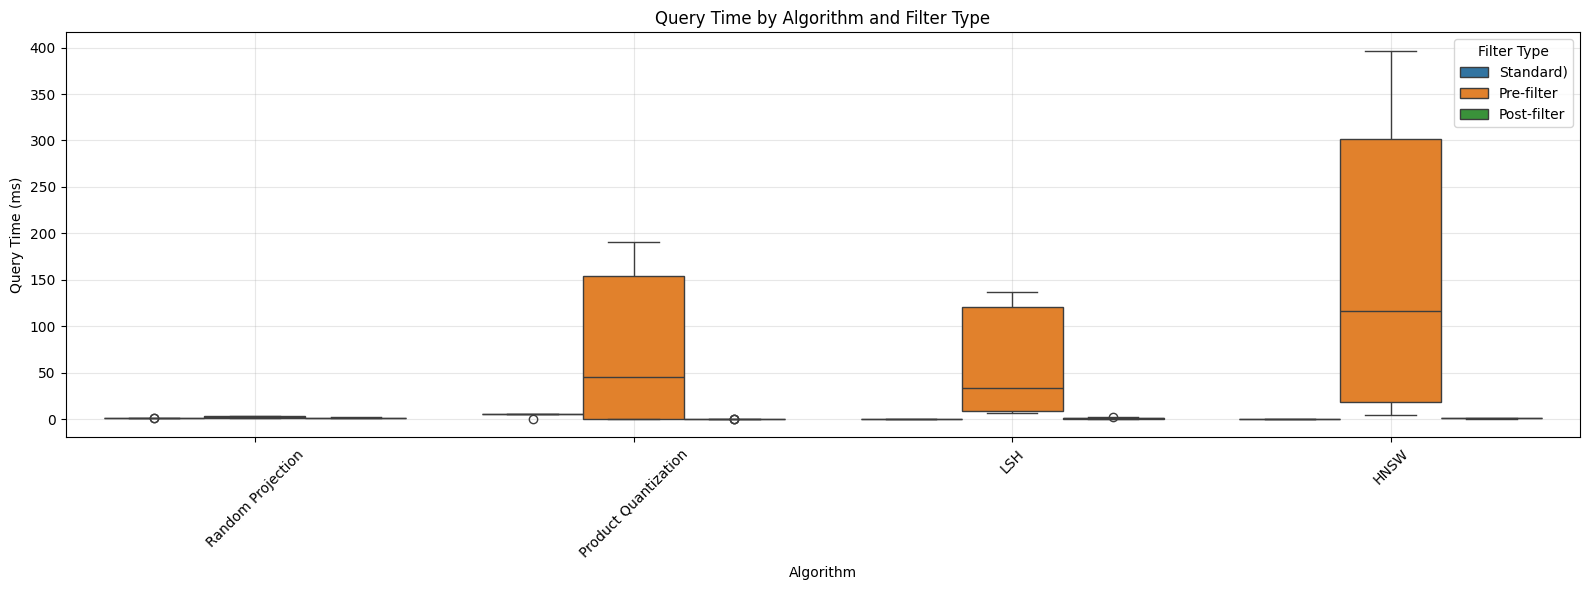

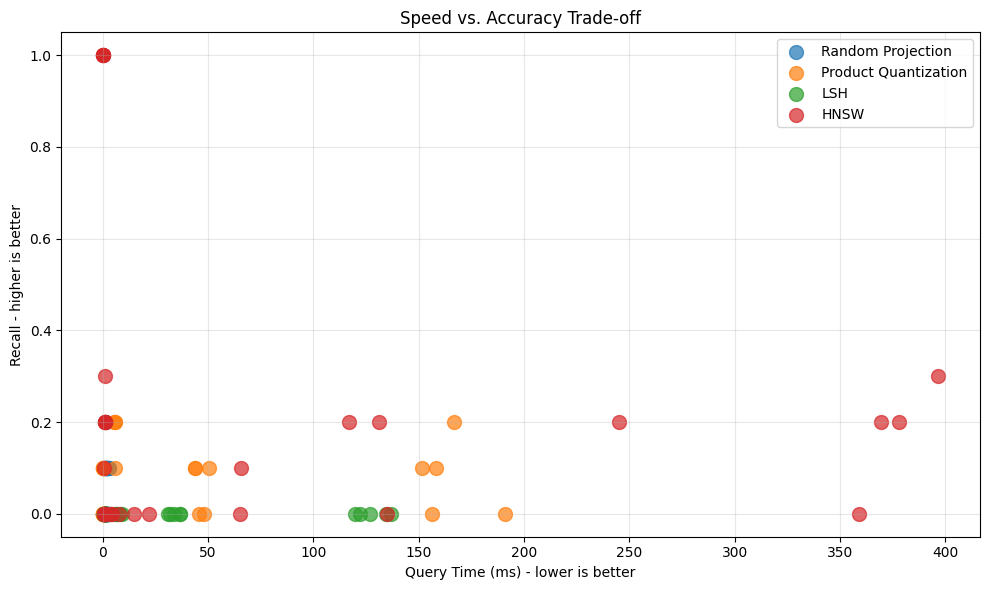


    Conclusion and Key Takeaways
    
    1. Algorithm Performance:
       - HNSW typically provides the best balance of speed and accuracy
       - Product Quantization offers good compression but with accuracy trade-offs
       - Random Projection is simple but less accurate for high-dimensional data
       - LSH works well for approximate similarity but can miss relevant results
    
    2. Filtering Approaches:
       - Pre-filtering reduces the search space early but may miss relevant results
       - Post-filtering ensures more accurate results but is generally slower
       - The optimal approach depends on:
         * Filter selectivity (how many items pass the filter)
         * Required recall/precision balance
         * Performance constraints
    
    3. Implementation Considerations:
       - Memory usage varies significantly between algorithms
       - Index build time can be important for dynamic data
       - Some algorithms are more suitable for specific distance met

In [30]:
def main():
    """Main function to execute the experiments"""
    # Print intro message
    print("""
    =======================================================================
    Vector Similarity Search Algorithms - Comparative Implementation
    =======================================================================

    This notebook implements and compares four popular vector search algorithms:
    1. Random Projection
    2. Product Quantization
    3. Locality-Sensitive Hashing (LSH)
    4. Hierarchical Navigable Small World (HNSW)

    Each algorithm is implemented with both pre-filtering and post-filtering
    approaches for metadata filtering.

    We'll generate a dummy dataset and compare the algorithms in terms of:
    - Search quality (recall)
    - Search speed (query time)

    Let's get started!
    """)

    # Run detailed experiments
    results_df, agg_results = run_experiments()

    # Additional visualization and analysis
    print("\nVisualizing algorithms' performance across different filtering approaches...")

    # Filter types comparison
    plt.figure(figsize=(16, 6))

    # Group by algorithm type (ignoring filter details)
    results_df['base_algorithm'] = results_df['algorithm'].apply(
        lambda x: x.split(' (')[0] if ' (' in x else x
    )

    results_df['filter_type'] = results_df['algorithm'].apply(
        lambda x: x.split('(')[1].split(':')[0].strip() if '(' in x else 'Standard'
    )

    # Plot comparison by filter type
    sns.boxplot(x='base_algorithm', y='query_time_ms', hue='filter_type', data=results_df)
    plt.title('Query Time by Algorithm and Filter Type')
    plt.xlabel('Algorithm')
    plt.ylabel('Query Time (ms)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Filter Type')
    plt.tight_layout()
    plt.show()

    # Show recall vs speed scatter plot
    plt.figure(figsize=(10, 6))
    for algo in results_df['base_algorithm'].unique():
        algo_data = results_df[results_df['base_algorithm'] == algo]
        plt.scatter(
            algo_data['query_time_ms'],
            algo_data['recall'],
            label=algo,
            alpha=0.7,
            s=100
        )

    plt.title('Speed vs. Accuracy Trade-off')
    plt.xlabel('Query Time (ms) - lower is better')
    plt.ylabel('Recall - higher is better')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print conclusions
    print("""
    =======================================================================
    Conclusion and Key Takeaways
    =======================================================================

    1. Algorithm Performance:
       - HNSW typically provides the best balance of speed and accuracy
       - Product Quantization offers good compression but with accuracy trade-offs
       - Random Projection is simple but less accurate for high-dimensional data
       - LSH works well for approximate similarity but can miss relevant results

    2. Filtering Approaches:
       - Pre-filtering reduces the search space early but may miss relevant results
       - Post-filtering ensures more accurate results but is generally slower
       - The optimal approach depends on:
         * Filter selectivity (how many items pass the filter)
         * Required recall/precision balance
         * Performance constraints

    3. Implementation Considerations:
       - Memory usage varies significantly between algorithms
       - Index build time can be important for dynamic data
       - Some algorithms are more suitable for specific distance metrics

    This implementation provides a foundation for understanding vector search
    algorithms and their practical application with metadata filtering.
    """)

if __name__ == "__main__":
    main()
